In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import requests
import math 
from math import floor
from scipy.stats.mstats import winsorize
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Importo il dataset con i prezzi

In [2]:
df = pd.read_csv("file3.csv")

In [3]:
df.head()

,Date,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
0,2016-01-01,0.948024,434.33,0.005955,3.51,0.001748,562.00,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
1,2016-01-02,0.937124,433.44,0.006065,3.50,0.001741,562.00,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
2,2016-01-03,0.971905,430.01,0.006017,3.48,0.001744,562.00,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
3,2016-01-04,0.954480,433.09,0.005958,3.50,0.001748,544.20,1075.2,2735.571521,168.805923,2009.1,32.37,2.77
4,2016-01-05,0.950176,431.96,0.006044,3.47,0.001721,535.75,1078.4,2717.819530,168.101637,2011.7,32.89,2.75


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1827 entries, 0 to 1826
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1827 non-null   object 
 1   ETH        1827 non-null   float64
 2   BTC        1827 non-null   float64
 3   XRP        1827 non-null   float64
 4   LTC        1827 non-null   float64
 5   XLM        1827 non-null   float64
 6   Palladium  1827 non-null   float64
 7   Gold       1827 non-null   float64
 8   HSI        1827 non-null   float64
 9   N225       1827 non-null   float64
 10  SP500      1827 non-null   float64
 11  NVIDIA     1827 non-null   float64
 12  AMD        1827 non-null   float64
dtypes: float64(12), object(1)
memory usage: 185.7+ KB


In [5]:
df['Date'] = pd.to_datetime(df['Date'],format = "%Y-%m-%d")

In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2016-01-01 to 2020-12-31
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ETH        1827 non-null   float64
 1   BTC        1827 non-null   float64
 2   XRP        1827 non-null   float64
 3   LTC        1827 non-null   float64
 4   XLM        1827 non-null   float64
 5   Palladium  1827 non-null   float64
 6   Gold       1827 non-null   float64
 7   HSI        1827 non-null   float64
 8   N225       1827 non-null   float64
 9   SP500      1827 non-null   float64
 10  NVIDIA     1827 non-null   float64
 11  AMD        1827 non-null   float64
dtypes: float64(12)
memory usage: 185.6 KB


In [8]:
df.head(3)

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-01,0.948024,434.33,0.005955,3.51,0.001748,562.0,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
2016-01-02,0.937124,433.44,0.006065,3.50,0.001741,562.0,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
2016-01-03,0.971905,430.01,0.006017,3.48,0.001744,562.0,1060.2,2810.900488,174.137258,2035.4,32.96,2.87


## Model

scalare il dataset e metterlo in forma di array

In [9]:
nrows = df.shape[0]
np_data = np.reshape(np.array(df), (nrows, -1))

In [10]:
# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data = scaler.fit_transform(np_data)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(df['BTC'])
np_BTC_scaled = scaler_pred.fit_transform(df_Close)

In [11]:
type(np_data)

numpy.ndarray

In [12]:
np_data.shape

(1827, 12)

In [13]:
np_data[0]

array([7.81091634e-06, 2.44435684e-03, 2.49786067e-04, 1.43524512e-03,
       3.39747179e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
       3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02])

In [14]:
type(np_data)

numpy.ndarray

la variabile target viene scelta, posso scegliere qualsiasi variabile

In [15]:
index = df.columns.get_loc("BTC")
index

1

In [16]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 1 # = number of neurons in the first layer of the neural network

# Prediction Index

index_Close = index

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data.shape[0] * 0.9)

# Create the training and test data
train_data = np_data[0:train_data_len, :]
test_data = np_data[train_data_len - sequence_length:, :]

In [17]:
def split_series(series, n_past, n_future):
  #
  # n_past ==> no of past observations
  #
  # n_future ==> no of future observations 
  #
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
              break
    # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end,index_Close]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)
n_past = 1
n_future = 1


n_past e n_future ti dicono rispettitivamente quanti giorni indietro saranno presi in considerazione per la predizione, e quanti giorni avanti sarà la variabile target.

In [18]:
# Generate training data and test data
x_train, y_train = split_series(train_data,n_past, n_future)
x_test, y_test = split_series(test_data,n_past, n_future)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][n_past-1][index_Close])
print(y_train[0])

(1644, 1, 12) (1644, 1)
(182, 1, 12) (182, 1)
0.0024132785843961335
[0.00241328]


creo il dataset di train e di test e faccio un check per vedere se la seconda finestra di dati contiene il risultato della prima

In [19]:
x_train[0:6]

array([[[7.81091634e-06, 2.44435684e-03, 2.49786067e-04, 1.43524512e-03,
         3.39747179e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
         3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02]],

       [[0.00000000e+00, 2.41327858e-03, 2.82379741e-04, 1.40710306e-03,
         3.31924053e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
         3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02]],

       [[2.49239891e-05, 2.29350510e-03, 2.68157047e-04, 1.35081893e-03,
         3.35276821e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
         3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02]],

       [[1.24372719e-05, 2.40105680e-03, 2.50674985e-04, 1.40710306e-03,
         3.39747179e-04, 3.31861368e-02, 1.48632580e-02, 2.02738936e-01,
         2.77340254e-01, 9.77598898e-02, 1.28306356e-02, 1.01762484e-02]],

       [[9.35303487e-06, 2.36159790e-03, 2.76157312e-04, 1.32267687e-03,
         3.09572265e-04, 2.94170124e-02

In [20]:
#ti da come y i 5 dati futuri di BTC
y_train[0:6]

array([[0.00241328],
       [0.00229351],
       [0.00240106],
       [0.0023616 ],
       [0.00226208],
       [0.00327264]])

In [21]:
x_train.shape, y_train.shape

((1644, 1, 12), (1644, 1))

In [22]:
x_test.shape, y_test.shape

((182, 1, 12), (182, 1))

In [23]:
len(x_train)

1644

In [24]:
df.head(3)

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-01,0.948024,434.33,0.005955,3.51,0.001748,562.0,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
2016-01-02,0.937124,433.44,0.006065,3.50,0.001741,562.0,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
2016-01-03,0.971905,430.01,0.006017,3.48,0.001744,562.0,1060.2,2810.900488,174.137258,2035.4,32.96,2.87


In [25]:
list1 = []
for i in range(y_train.shape[0]):
      list1.append(y_train[i][-1])
#print(i)        

In [26]:
list2 = []
for i in range(len(y_test)):
      list2.append(y_test[i][-1])

In [27]:
y_train = np.array(list1)

In [28]:
y_train.shape[0]

1644

In [29]:
y_train.shape

(1644,)

In [30]:
y_test = np.array(list2)

In [31]:
y_test.shape

(182,)

In [32]:
#x_train[0:6]

In [33]:
#y_train[0:6]

In [34]:
x_train[1]

array([[0.00000000e+00, 2.41327858e-03, 2.82379741e-04, 1.40710306e-03,
        3.31924053e-04, 4.11258308e-02, 0.00000000e+00, 2.42327707e-01,
        3.23529571e-01, 1.11687761e-01, 1.38893874e-02, 1.12253462e-02]])

In [35]:
y_train[1]

0.002293505099452151

## LSTM

creazione della rete, settaggio dei vari layer e dei parametri

In [36]:
n_neurons = x_train.shape[1] * x_train.shape[2]

In [37]:
n_neurons

12

In [38]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.optimizers import Adam


def createModel(l1Nodes, l2Nodes, d1Nodes, d2Nodes, inputShape):
    # input layer
    lstm1 = LSTM(l1Nodes, input_shape=inputShape, return_sequences=True)
    lstm2 = LSTM(l2Nodes, return_sequences=True)
    flatten = Flatten()
    dense1 = Dense(d1Nodes)
    dense2 = Dense(d2Nodes)

    # output layer
#     outL = Dense(1, activation='relu')
    outL = Dense(1)
    # combine the layers
    layers = [lstm1, lstm2, flatten,  dense1, dense2, outL]
    # create the model
    model = Sequential(layers)
    opt = Adam(learning_rate=0.005)
    model.compile(optimizer=opt, loss='mse')
    return model

In [39]:
model = createModel(12,12, 8, 4, (x_train.shape[1], x_train.shape[2]))
model.fit(x_train, y_train, batch_size=12, epochs=10, validation_data = (x_test, y_test))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 1644 samples, validate on 182 samples
Epoch 1/10
1644/1644 [==============================] - 1s 463us/step - loss: 0.0069 - val_loss: 0.0083
Epoch 2/10
1644/1644 [==============================] - 0s 150us/step - loss: 8.2453e-04 - val_loss: 0.0021
Epoch 3/10
1644/1644 [==============================] - 0s 159us/step - loss: 3.2836e-04 - val_loss: 0.0013
Epoch 4/10
1644/1644 [==============================] - 0s 165us/step - loss: 2.8877e-04 - val_loss: 0.0021
Epoch 5/10
1644/1644 [==============================] - 0s 170us/step - loss: 2.5007e-04 - val_loss: 0.0039
Epoch 6/10
1644/1644 [==============================] - 0s 159us/step - loss: 2.4129e-04 - val_loss: 0.0047
Epoch 7/10
1644/1644 [==============================] - 0s 166us/step - loss: 2.3029e-04 - val_loss: 0.0038
Epoch 8/10
1644/1644 [==============================] - 0s 158us/step - loss: 2.2450e-04 - val_loss: 0.0033
Epoch 9/10


#### predizione del modello

In [40]:
from sklearn.metrics import mean_squared_error as mse

In [41]:
y_pred_train = model.predict(x_train)
mse(y_train, y_pred_train)

0.00018059341024887962

In [42]:
y_pred = model.predict(x_test)
mse(y_test, y_pred)

0.004833487756136499

In [43]:
y_pred.shape

(182, 1)

In [44]:
y_test.shape

(182,)

In [45]:
df["BTC"].iloc[train_data_len - sequence_length:]

Date
2020-07-02     9123.41
2020-07-03     9087.30
2020-07-04     9132.49
2020-07-05     9073.94
2020-07-06     9375.47
                ...   
2020-12-27    26272.29
2020-12-28    27084.81
2020-12-29    27362.44
2020-12-30    28840.95
2020-12-31    29001.72
Name: BTC, Length: 183, dtype: float64

In [46]:
#y_test

In [47]:
y_pred[0:5]

array([[0.30878955],
       [0.3079803 ],
       [0.30963463],
       [0.3080284 ],
       [0.3180632 ]], dtype=float32)

In [48]:
def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction',color='red') 
    plt.legend() 
    plt.show()

In [49]:
#plot_results(y_pred,y_test)

In [50]:
y_pred_noscaled = scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [51]:
#y_test_unscaled

In [52]:
#y_pred_noscaled

#### grafico dei risultati del test set dopo avere riportato i dati al loro valore originale(non scalati)

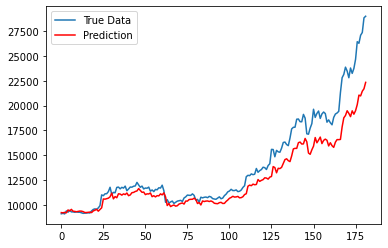

In [53]:
plot_results(y_pred_noscaled,y_test_unscaled)

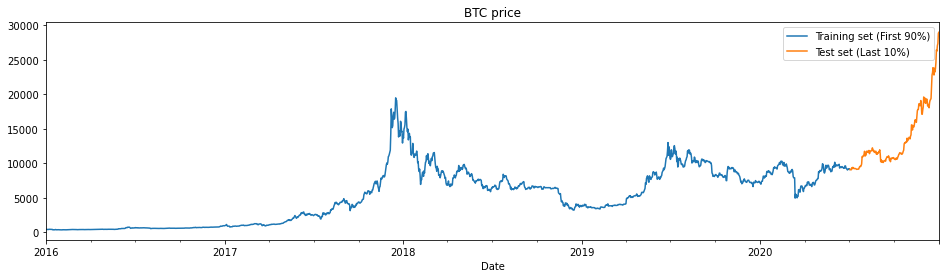

In [54]:
df["BTC"].iloc[0:train_data_len].plot(figsize=(16,4),legend=True)
df["BTC"].iloc[train_data_len - n_past:].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%)','Test set (Last 10%)'])
plt.title('BTC price')
plt.show()

In [55]:
df.head()

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
Date,,,,,,,,,,,,
2016-01-01,0.948024,434.33,0.005955,3.51,0.001748,562.00,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
2016-01-02,0.937124,433.44,0.006065,3.50,0.001741,562.00,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
2016-01-03,0.971905,430.01,0.006017,3.48,0.001744,562.00,1060.2,2810.900488,174.137258,2035.4,32.96,2.87
2016-01-04,0.954480,433.09,0.005958,3.50,0.001748,544.20,1075.2,2735.571521,168.805923,2009.1,32.37,2.77
2016-01-05,0.950176,431.96,0.006044,3.47,0.001721,535.75,1078.4,2717.819530,168.101637,2011.7,32.89,2.75


In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 12)             1200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 12)             1200      
_________________________________________________________________
flatten_1 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 2,545
Trainable params: 2,545
Non-trainable params: 0
____________________________________________________

In [57]:
#!pip install shap==0.40.0

Importo shap dopo averlo installato

In [58]:
import shap

In [59]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [60]:
x_test[1]

array([[0.16084244, 0.30460073, 0.05073472, 0.10753082, 0.07354297,
        0.65025202, 0.72314705, 0.47548078, 0.58294108, 0.71355187,
        0.64470804, 0.53021402]])

In [61]:
x_test[1:2]

array([[[0.16084244, 0.30460073, 0.05073472, 0.10753082, 0.07354297,
         0.65025202, 0.72314705, 0.47548078, 0.58294108, 0.71355187,
         0.64470804, 0.53021402]]])

In [62]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, x_train)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(x_test)
# init the JS visualization code
shap.initjs()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


keras is no longer supported, please use tf.keras instead.


Utilizzo il DeepExplainer sul tutto il training set e calcolo gli shapley values sul test set

In [63]:
shap_values

[array([[[ 1.20022992e-03,  1.16500460e-01, -9.49576329e-04, ...,
          -5.68362140e-03,  1.41422157e-02, -9.42946090e-03]],
 
        [[ 1.14254141e-03,  1.15546230e-01, -9.55770748e-04, ...,
          -5.76383711e-03,  1.41064046e-02, -9.39984105e-03]],
 
        [[ 1.19654790e-03,  1.16981642e-01, -9.45277241e-04, ...,
          -5.75073363e-03,  1.40519931e-02, -9.41401626e-03]],
 
        ...,
 
        [[ 6.07528913e-03,  5.76336367e-01, -1.18797549e-04, ...,
          -3.86093697e-03, -1.49171090e-03, -4.53988803e-02]],
 
        [[ 6.03246961e-03,  5.82846602e-01, -1.54415369e-04, ...,
          -3.96940019e-03, -1.84969790e-03, -4.54035937e-02]],
 
        [[ 6.02126433e-03,  6.11433077e-01, -1.17770604e-04, ...,
          -3.54667825e-03, -3.48832733e-03, -4.75407120e-02]]])]

L' expected value sarebbe il valore base, ovvero il modello senza feature(average dei dati target)

In [64]:
explainer.expected_value

array([0.17159489], dtype=float32)

In [65]:
y_test[1:2]

array([0.30617874])

In [66]:
y_pred[1:2]

array([[0.3079803]], dtype=float32)

In [67]:
len(shap_values)

1

#### check sulla dimensione dei dati e degli shapley values, devono matchare

In [68]:
x_test.shape

(182, 1, 12)

In [69]:
shap_values[0].shape

(182, 1, 12)

In [70]:
shap_values[0][0].shape

(1, 12)

In [71]:
features = list(df.columns)

In [72]:
features

['ETH',
 'BTC',
 'XRP',
 'LTC',
 'XLM',
 'Palladium',
 'Gold',
 'HSI',
 'N225',
 'SP500',
 'NVIDIA',
 'AMD']

In [73]:
i=0
j=0

In [74]:
#shap_values[0][i][j]

In [75]:
#x_test[i][j].shape

In [76]:
explainer.expected_value[0], shap_values[0][i][j]

(0.17159489,
 array([ 0.00120023,  0.11650046, -0.00094958, -0.00286426,  0.00092322,
         0.00178019,  0.01370768,  0.00289909,  0.0049685 , -0.00568362,
         0.01414222, -0.00942946]))

In [77]:
x_test_df = pd.DataFrame(data=x_test[i][j].reshape(1,12), columns = features)

In [78]:
x_test_df

,ETH,BTC,XRP,LTC,XLM,Palladium,Gold,HSI,N225,SP500,NVIDIA,AMD
0,0.163709,0.305862,0.051004,0.108319,0.074836,0.650252,0.723147,0.4587,0.570218,0.713552,0.644708,0.530214


In [79]:
shap_values[0]

array([[[ 1.20022992e-03,  1.16500460e-01, -9.49576329e-04, ...,
         -5.68362140e-03,  1.41422157e-02, -9.42946090e-03]],

       [[ 1.14254141e-03,  1.15546230e-01, -9.55770748e-04, ...,
         -5.76383711e-03,  1.41064046e-02, -9.39984105e-03]],

       [[ 1.19654790e-03,  1.16981642e-01, -9.45277241e-04, ...,
         -5.75073363e-03,  1.40519931e-02, -9.41401626e-03]],

       ...,

       [[ 6.07528913e-03,  5.76336367e-01, -1.18797549e-04, ...,
         -3.86093697e-03, -1.49171090e-03, -4.53988803e-02]],

       [[ 6.03246961e-03,  5.82846602e-01, -1.54415369e-04, ...,
         -3.96940019e-03, -1.84969790e-03, -4.54035937e-02]],

       [[ 6.02126433e-03,  6.11433077e-01, -1.17770604e-04, ...,
         -3.54667825e-03, -3.48832733e-03, -4.75407120e-02]]])

#### Grafico dei contributi per la prima osservazione nel test set

In [80]:
# shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)
shap.initjs()
i = 0
j = 0
x_test_df = pd.DataFrame(data=x_test[i][j].reshape(1,12), columns = features)
shap.force_plot(explainer.expected_value[0], shap_values[0][i][j], x_test_df, matplotlib=False,show=True, figsize=(23, 4), text_rotation=0)

In [81]:
from shap.plots import _waterfall

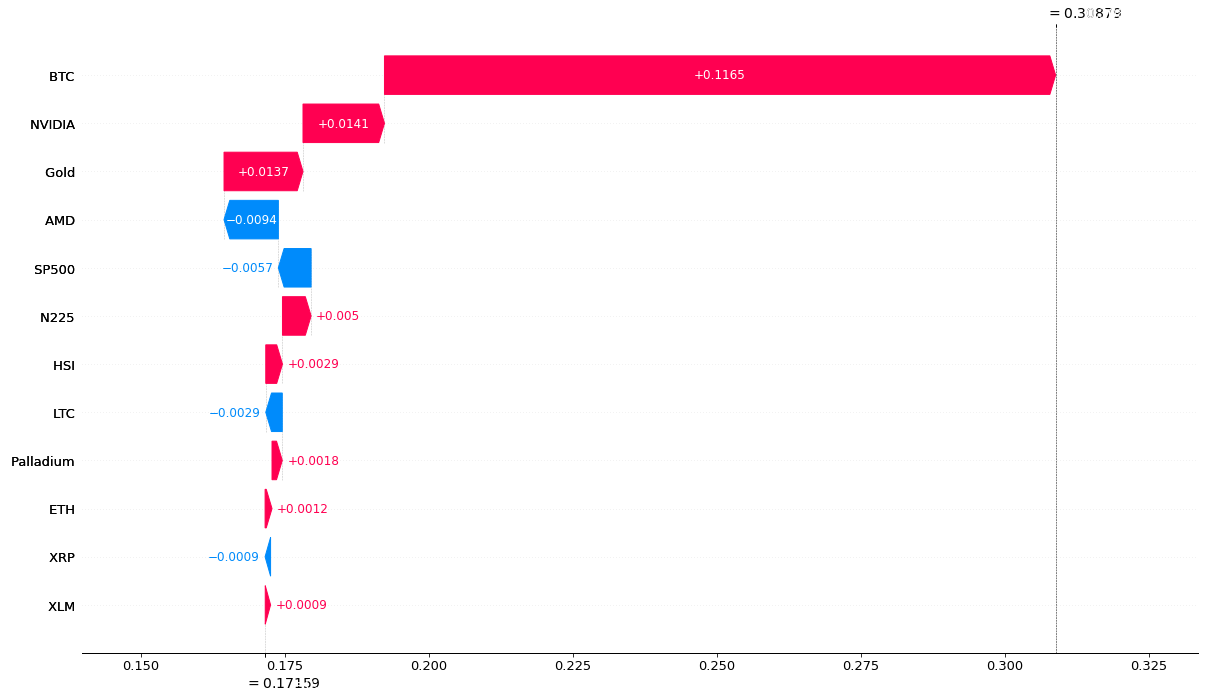

In [82]:
import matplotlib.pyplot as pl
import matplotlib
_waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0][0],x_test_df.iloc[0],max_display=12)


In [83]:
#devo guardare y_pred e non y_test
#y_pred

#### check sulla somma degli shapley values della prima osservazione al valore base che deve essere uguale alla predizione della prima osservazione

In [84]:

pred_i = model.predict(x_test)
sum_shap_i = shap_values[0][0].sum() + explainer.expected_value[0]

pred_i[0], sum_shap_i

(array([0.30878955], dtype=float32), 0.3087895605091755)

In [85]:
shap.__version__

'0.40.0'

#### modifico la dimensione dei dati e degli shapley values in maniera tale da analizzarli globalmente

In [86]:
shap_values_2D = shap_values[0].reshape(-1,12)
x_test_2D = x_test.reshape(-1,12)


shap_values_2D.shape, x_test_2D.shape

((182, 12), (182, 12))

In [87]:
shap_values_2D

array([[ 1.20022992e-03,  1.16500460e-01, -9.49576329e-04, ...,
        -5.68362140e-03,  1.41422157e-02, -9.42946090e-03],
       [ 1.14254141e-03,  1.15546230e-01, -9.55770748e-04, ...,
        -5.76383711e-03,  1.41064046e-02, -9.39984105e-03],
       [ 1.19654790e-03,  1.16981642e-01, -9.45277241e-04, ...,
        -5.75073363e-03,  1.40519931e-02, -9.41401626e-03],
       ...,
       [ 6.07528913e-03,  5.76336367e-01, -1.18797549e-04, ...,
        -3.86093697e-03, -1.49171090e-03, -4.53988803e-02],
       [ 6.03246961e-03,  5.82846602e-01, -1.54415369e-04, ...,
        -3.96940019e-03, -1.84969790e-03, -4.54035937e-02],
       [ 6.02126433e-03,  6.11433077e-01, -1.17770604e-04, ...,
        -3.54667825e-03, -3.48832733e-03, -4.75407120e-02]])

In [88]:
x_test_2d = pd.DataFrame(data=x_test_2D, columns = features)

In [89]:
x_test

array([[[0.16370884, 0.30586167, 0.05100377, ..., 0.71355187,
         0.64470804, 0.53021402]],

       [[0.16084244, 0.30460073, 0.05073472, ..., 0.71355187,
         0.64470804, 0.53021402]],

       [[0.16347952, 0.30617874, 0.05122303, ..., 0.71355187,
         0.64470804, 0.53021402]],

       ...,

       [[0.52273151, 0.93306268, 0.07195676, ..., 0.98342424,
         0.88070201, 0.9420898 ]],

       [[0.5235341 , 0.94275735, 0.06395768, ..., 0.98342424,
         0.88380648, 0.93180864]],

       [[0.53793772, 0.99438601, 0.06125122, ..., 0.98342424,
         0.89834189, 0.94932858]]])

In [90]:
# x_test_2d

In [91]:
#x_test_2d.corr()

#### grafico globale dei contributi di ogni variabile utilizzando gli shapley values

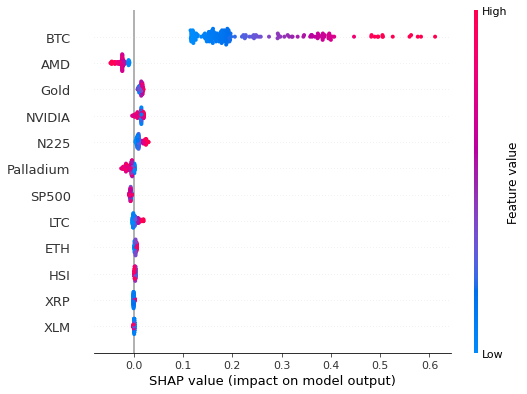

In [92]:
shap.initjs()
shap.summary_plot(shap_values_2D, x_test_2d)

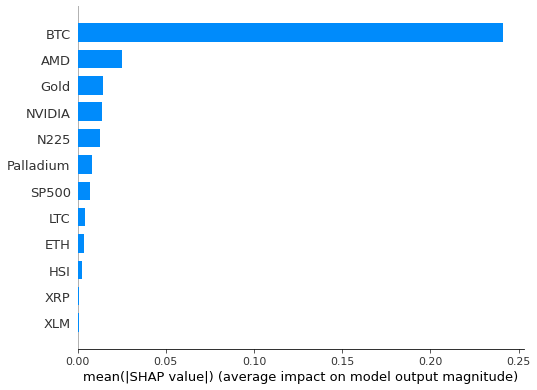

In [93]:
shap.initjs()
shap.summary_plot(shap_values_2D, x_test_2d, plot_type="bar")